# Analysis of courier daily activity dataset: Multiple Day prediction

## Prediction task: Multiple-Day tasks

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Multiple-Day task consists of predicting the 'courier_partners_online' for the several next days based on the information available for the previous days.
 </p>
</div>

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Import necessary packages</p>
</div>

In [67]:
import pandas as pd
import numpy as np
import os
from scipy import fftpack  # or 'fft'
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from wolt_test_assignment.config import PROCESSED_DATA_DIR, RAW_DATA_DIR
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance
from datetime import datetime, timedelta
%matplotlib inline

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Define utility functions 
 </p>
</div>

In [68]:
def plot_prediction(y_test_original, predicted_courier_number_original, start_date):
    """
    Plot the real and predicted values for courier partners online.

    Parameters:
    y_test_original (array-like): The original test values (real values).
    predicted_courier_number_original (array-like): The predicted values from the model.

    Returns:
    None
    """
    date_range = pd.date_range(start=start_date, periods=len(y_test_original))
    plt.plot(date_range, y_test_original, color='red', marker='+', label="Real")
    plt.plot(date_range, predicted_courier_number_original, color="blue", marker='o', label="Predicted")
    plt.title("Prediction")
    plt.xlabel("Day")
    plt.ylabel("Number of Courier Partners Online")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()


<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Load, clean dataset and define features
 </p>
</div>

In [69]:
file_name = os.path.join(RAW_DATA_DIR, "daily_cp_activity_dataset.csv")
df_daily_activity = pd.read_csv(file_name)
df_daily_activity['date'] = pd.to_datetime(df_daily_activity['date'])
anomaly_threshold = 500
df_daily_activity_cleaned = df_daily_activity.copy(deep= True)
df_daily_activity_cleaned.loc [df_daily_activity['courier_partners_online']>500, 'courier_partners_online'] = None
df_daily_activity_cleaned = df_daily_activity_cleaned.ffill()

In [70]:
df_daily_activity_cleaned['day_of_week'] = df_daily_activity_cleaned['date'].dt.dayofweek
df_daily_activity_cleaned = pd.get_dummies(df_daily_activity_cleaned, columns=['day_of_week'])

##################################33
# Define a reference date for trend calculation
start_date = df_daily_activity_cleaned['date'].min()
REFERENCE_DATE = start_date 

# Transform the 'date' column
df_daily_activity_cleaned['days_since_start'] = (df_daily_activity_cleaned['date'] - REFERENCE_DATE).dt.days
df_daily_activity_cleaned['day_of_year_sin'] = np.sin(2 * np.pi * df_daily_activity_cleaned['date'].dt.dayofyear / 365)
df_daily_activity_cleaned['day_of_year_cos'] = np.cos(2 * np.pi * df_daily_activity_cleaned['date'].dt.dayofyear / 365)


<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Define set of features. Welcome to experiment and select different sets and see what happens with predictions below </p>
</div>

In [71]:
features = ['courier_partners_online', 'precipitation', 'temperature'] + \
    [col for col in df_daily_activity_cleaned.columns if col.startswith('day_of_week')]
# Update the features list to include the new date features'
#print(len(features))

date_features = ['days_since_start', 'day_of_year_sin', 'day_of_year_cos']
#features += date_features

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
  <p> 
    To train, test, and validate the model, we will split the data into training, validation, and testing sets. We will use the first 70% portion of the data for training, the middle portion 10% for validation, and the last 20% portion for testing. 
  </p>
</div>

In [72]:
duration_train = int(0.6*df_daily_activity_cleaned.shape [0])
duration_val = int(0.2*df_daily_activity_cleaned.shape [0])
start_date = (df_daily_activity_cleaned["date"].iloc[0])

# Calculate the validation start date
SPLIT_DATE_TRAIN_END = start_date + timedelta(duration_train)
SPLIT_DATE_TEST = start_date + timedelta(duration_train) + timedelta(duration_val)

SPLIT_DATE_TRAIN_END = SPLIT_DATE_TRAIN_END.strftime("%Y-%m-%d")
SPLIT_DATE_TEST = SPLIT_DATE_TEST.strftime("%Y-%m-%d")

print(SPLIT_DATE_TRAIN_END, SPLIT_DATE_TEST)

SPLIT_DATE_TEST = "2023-01-01"
SPLIT_DATE_TRAIN_END = "2022-10-15"

#SPLIT_DATE_TRAIN_END = "2022-07-31"

2022-07-31 2022-12-30


In [73]:
total_set = df_daily_activity_cleaned[features].values
training_set = df_daily_activity_cleaned[features][df_daily_activity_cleaned['date'] < SPLIT_DATE_TRAIN_END].values

val_set = df_daily_activity_cleaned[(df_daily_activity_cleaned['date'] >= SPLIT_DATE_TRAIN_END) & (df_daily_activity_cleaned['date'] < SPLIT_DATE_TEST)][features].values
test_set = df_daily_activity_cleaned[features][df_daily_activity_cleaned['date'] >= SPLIT_DATE_TEST].values

SC = StandardScaler()

# Fit the scaler on the total set and transform both training and test sets
SC.fit(total_set)
total_set_scaled = SC.transform(total_set)
training_set_scaled = SC.transform(training_set)
test_set_scaled = SC.transform(test_set)
val_set_scaled = SC.transform(val_set)


## LSTM model definition

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Define RNN model, namely the Long-Short-Term_Memory multilayer model for time series forecasting
 </p>
</div>

In [74]:
def create_lstm_model(input_shape, n_steps):
    """
    Create and compile an LSTM model with Dropout regularization.

    Parameters:
    input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    model (Sequential): Compiled LSTM model.
    """
    regressor = Sequential()

    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    regressor.add(Dropout(0.3))

    # Second LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=80, return_sequences=True))
    regressor.add(Dropout(0.1))

    # Third LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))

    # Fourth LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=30))
    regressor.add(Dropout(0.3))

    # Output layer
    regressor.add(Dense(units=n_steps))

    # Compile the model
    regressor.compile(optimizer='adam', loss='mean_squared_error')

    return regressor

In [75]:
# Example usage
input_shape = (40, 10)  # Example input shape (timesteps, features)
n_steps = 1  # Example number of steps to predict
model = create_lstm_model(input_shape, n_steps)
model.summary()

c:\Users\mikes\Documents\JOB\wolt_test_assignment_2025\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 40, 100)        │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 40, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 40, 80)         │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 40, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 40, 50)         │        26,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 40, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,271 (540.12 KB)

 Trainable params: 138,271 (540.12 KB)

 Non-trainable params: 0 (0.00 B)

Simplified LSTM model

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

def create_lstm_model(input_shape, n_steps):
    """
    Create and compile a simplified LSTM model with fewer parameters and regularization.

    Parameters:
    input_shape (tuple): Shape of the input data (timesteps, features).
    n_steps (int): Number of output steps.

    Returns:
    model (Sequential): Compiled LSTM model.
    """
    model = Sequential()

    # Single LSTM layer with reduced units and L2 regularization
    model.add(LSTM(units=40, input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.1))  # Reduce Dropout to prevent losing too much information

    # Fully connected output layer
    model.add(Dense(units=n_steps))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [77]:
# Example usage
input_shape = (40, 10)  # Example input shape (timesteps, features)
n_steps = 1  # Example number of steps to predict
model = create_lstm_model(input_shape, n_steps)
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 40)             │         8,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,201 (32.04 KB)

 Trainable params: 8,201 (32.04 KB)

 Non-trainable params: 0 (0.00 B)

## Predicting courier numnber for the Multiple-Day task

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Let us perform multiple-step forecasting to predict courier numbers for several (20) future days.  First, prepare the training, validation and test datasets.
 </p>
</div>

### Analysis with Linear Regression models

In [78]:
training_days = 40  # Number of past days to use for prediction
n_steps = 14  # Number of future steps to predict

In [79]:
# Prepare the training data
X_train = []
y_train = []

for i in range(training_days, len(training_set_scaled) - n_steps + 1):
 
    X_train.append(training_set_scaled[i - training_days:i])
    y_train.append(training_set_scaled[i:i + n_steps, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))

#print(X_train.shape, y_train.shape)
#input()

# Prepare the test data
X_test = []
y_test = []
number_of_days_shift = 10
for i in range(training_days, len(test_set_scaled) - n_steps + 1 - number_of_days_shift):
    #X_test.append(test_set_scaled[i - training_days:i])
    y_test.append(test_set_scaled[i:i + n_steps, 0])
    X_test.append(test_set_scaled[i - training_days:i].flatten())  # Flatten for MultiOutputRegressor input

y_test_original = np.array(test_set[i:i+ n_steps, 0])
X_test = np.array(X_test)
#y_test = np.array(y_test)

split_date_dt = datetime.strptime(SPLIT_DATE_TEST, "%Y-%m-%d")
start_date = split_date_dt + timedelta( len(test_set_scaled) - n_steps)
start_date_str = start_date.strftime("%Y-%m-%d")

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Define and train Linear Regression model
 </p>
</div>

In [80]:

if n_steps == 1:
    y_train = y_train.flatten()  # Single-output regression
    model = LinearRegression()
else:
    model = MultiOutputRegressor(LinearRegression())  # Multi-step regression

model.fit(X_train, y_train)

MultiOutputRegressor(estimator=LinearRegression())

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Make prediction for the courier number several day ahead and plot it compared to the real data from the test set
 </p>
</div>

In [81]:
# Make predictions on the test set
predicted_courier_number = model.predict(X_test)
    
#y_test_original = test_target[ start_ind + training_days: start_ind + training_days + n_steps ].flatten() 
predicted_courier_number = predicted_courier_number[-1, :].flatten()   
          
# Create a placeholder array for inverse transform
predicted_full = np.zeros((predicted_courier_number.shape[0], training_set_scaled.shape[1]))   
        
predicted_full[:, 0] = predicted_courier_number.flatten()
   
predicted_original = SC.inverse_transform(predicted_full)

# Extract the original scale predictions for 'courier_partners_online'
predicted_courier_number_original = predicted_original[:, 0]
integer_predicted_courier_number = np.round(predicted_courier_number_original)

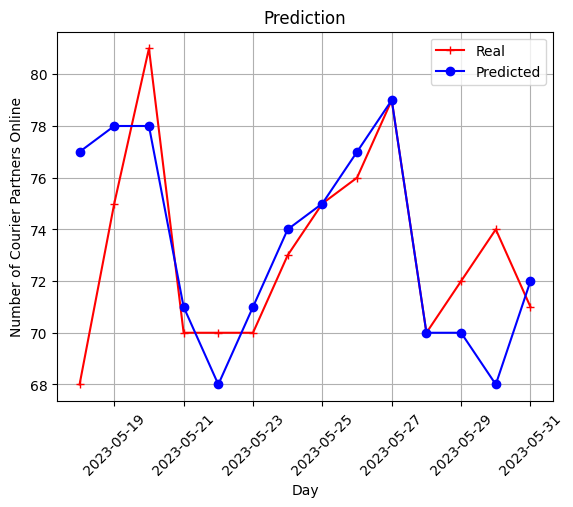

In [82]:
plot_prediction(y_test_original, integer_predicted_courier_number, start_date_str)

### Feature importance analysis for Linear Regression model

In [83]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

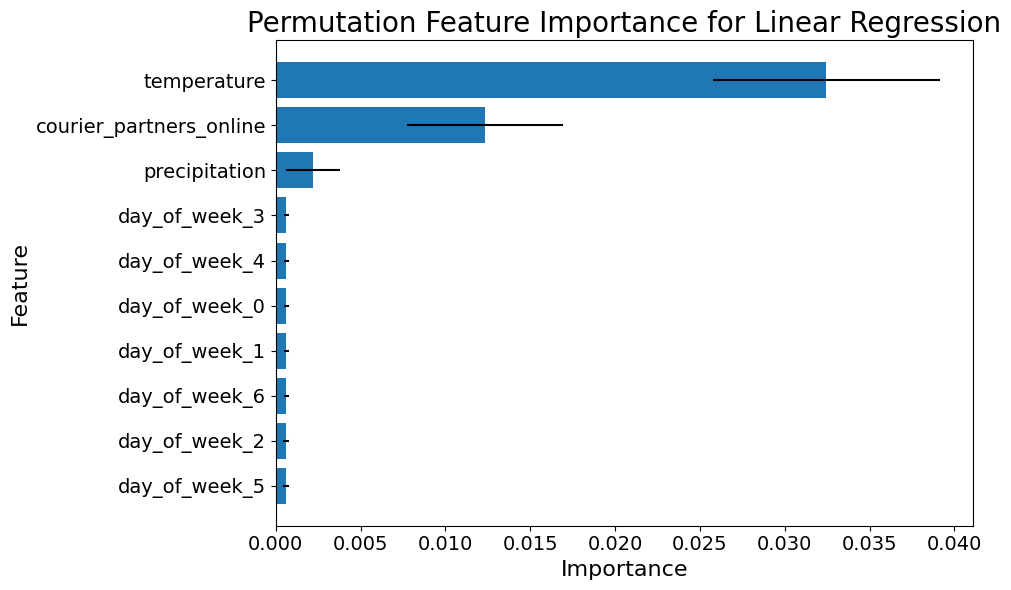

In [84]:
feature_number = len(features)  
feature_names = features

mean_coefs = np.mean( np.reshape(result.importances_mean, (training_days, feature_number) ), axis=0)   
std_coefs = np.mean( np.reshape(result.importances_std, (training_days, feature_number) ), axis=0)   

#mean_coefs = np.reshape(result.importances_mean, (training_days, feature_number) ) [39,:]
#std_coefs = np.reshape(result.importances_std, (training_days, feature_number) ) [39,:]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_coefs,
    'Importance_std': std_coefs
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Importance_std'])
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Permutation Feature Importance for Linear Regression', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Analysis with LSTM model

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Prepare datasets for LSTM models  </p>
</div>

In [85]:
# Prepare the training data
X_train = []
y_train = []

for i in range(training_days, len(training_set_scaled) - n_steps + 1):
    X_train.append(training_set_scaled[i - training_days:i])
    y_train.append(training_set_scaled[i:i + n_steps, 0])  # Predict 'n_steps' future values of 'courier_partners_online'    

X_train, y_train = np.array(X_train), np.array(y_train)
y_train = y_train.reshape(y_train.shape[0], -1)  # Flatten for Dense layer

# Prepare the test data
X_test = []
y_test = []
for i in range(training_days, len(test_set_scaled) - n_steps + 1):
    X_test.append(test_set_scaled[i - training_days:i])  # Flatten for MultiOutputRegressor input
    y_test.append(test_set_scaled[i:i + n_steps, 0])  # Predict 'n_steps' future values of 'courier_partners_online'

y_test_original = np.array(test_set[i:i+ n_steps, 0])
y_test_original_1 = np.array(test_set[0:0+ n_steps, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
y_test = y_test.reshape(y_test.shape[0], -1)  # Flatten for Dense layer

# Prepare the validation data
X_val = []
y_val = []
for i in range(training_days, len(val_set_scaled) - n_steps + 1):
    X_val.append(val_set_scaled[i - training_days:i])  # Flatten for MultiOutputRegressor input
    y_val.append(val_set_scaled[i:i + n_steps, 0])  # Predict 'n_steps' future values of 'courier_partners_online'

y_val_original = np.array(val_set[i:i+ n_steps, 0])
X_val, y_val = np.array(X_val), np.array(y_val)

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Train model and plot loss curves
 </p>
</div>

In [86]:
# Train the model and record the history
input_shape = (X_train.shape[1], X_train.shape[2])
regressor = create_lstm_model(input_shape, n_steps)
history= regressor.fit(X_train, y_train, epochs = 60, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/60


c:\Users\mikes\Documents\JOB\wolt_test_assignment_2025\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 1.0019 - val_loss: 1.2910
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.8150 - val_loss: 1.1471
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6451 - val_loss: 0.8640
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5349 - val_loss: 0.5897
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4399 - val_loss: 0.4364
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3996 - val_loss: 0.3820
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3536 - val_loss: 0.3520
Epoch 8/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3380 - val_loss: 0.3328
Epoch 9/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3119 - val_loss: 0.3185
Epoch 10/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3062 - val_loss: 0.3096
Epoch 11/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2974 - val_loss: 0.2967
Epoch 12/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2753 - val_

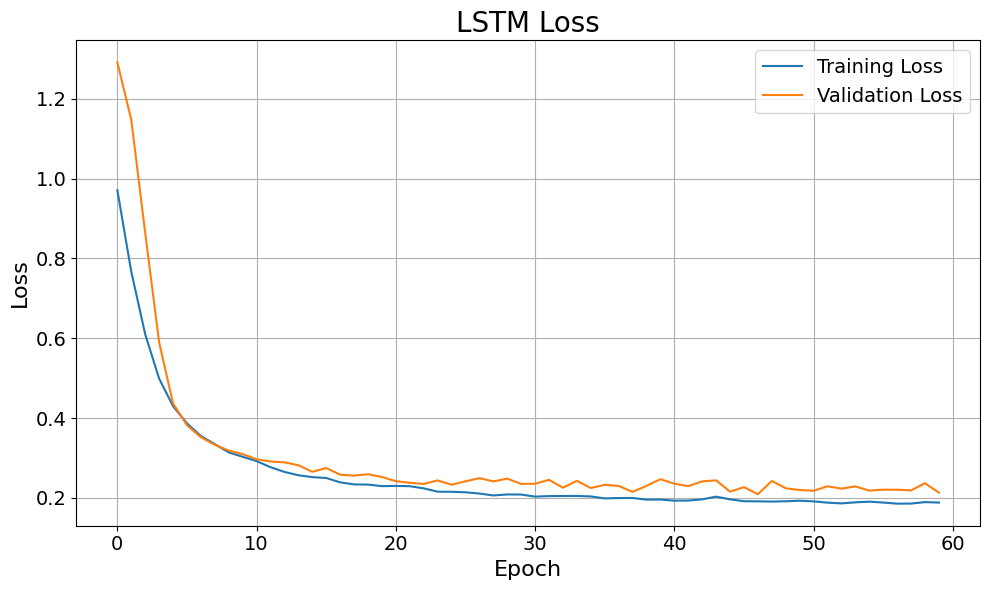

In [87]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid()

# Set font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Predict courier number for several day ahead and plot it compared to the real data from the test set
 </p>
</div>

X_test shape: (98, 40, 10)
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001FC6B3C09A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted courier number shape: (98, 14)
Predicted courier number shape: (14,)
Predicted_full shape: (14, 10)
Predicted_original shape: (14, 10)
Predicted_courier_number_

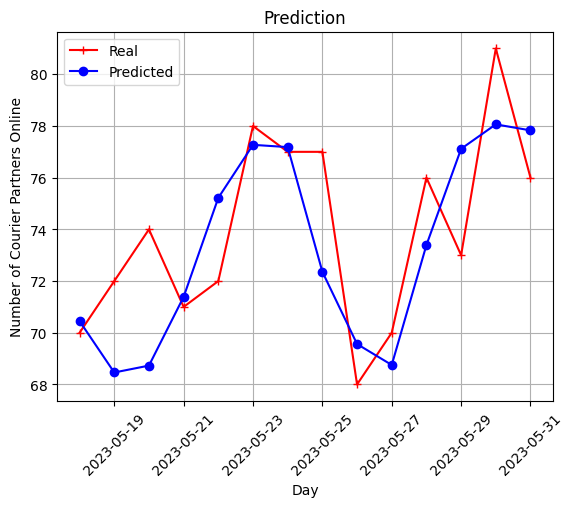

In [88]:

# Ensure the shape of X_test matches the model input
print("X_test shape:", X_test.shape)  # Should be (samples, training_days, features)

# Make predictions on the test set
predicted_courier_number = regressor.predict(X_test) 
print("Predicted courier number shape:", predicted_courier_number.shape)  # Should be (samples, n_steps)

predicted_courier_number = predicted_courier_number[-1, :].flatten()
print("Predicted courier number shape:", predicted_courier_number.shape)  # Should be (samples, n_steps)

# Create a placeholder array for inverse transform
predicted_full = np.zeros((predicted_courier_number.shape[0], total_set.shape[1]))
predicted_full[:, 0] = predicted_courier_number.flatten()

# Debug the placeholder shape
print("Predicted_full shape:", predicted_full.shape)  # Should match the shape required for SC.inverse_transform

# Inverse transform the predictions
predicted_original = SC.inverse_transform(predicted_full)

# Extract the original scale predictions for 'courier_partners_online'
predicted_courier_number_original = predicted_original[:, 0]
integer_predictions= np.round(predicted_courier_number_original).astype(int)

# Print shapes for debugging
print("Predicted_original shape:", predicted_original.shape)
print("Predicted_courier_number_original shape:", predicted_courier_number_original.shape)
    
# now we'll use this function to visualize our test and predicted data
plot_prediction(y_test_original, predicted_courier_number_original, start_date_str)

## Conclusions

We see that both LSTM models and baseline Linear Regression models can predict the courier number for multiple days (for example 7 or 14  days) ahead. For this Multiple-Day task the baseline Linear Regression model performs better than LSTM. Possible reason is the lack of training data for the LSTM model which has too many parameters. 

The quantitative metrics of the prediction accuracy such as Mean Square Error (MSE), RMSE, Signal-to-Noise Ratio (SNR) calculated in a pipeline using scripts described in README.md 